######  <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#35c337">NLP: Text Classification 

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#a9c335">Importing relevant libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Flatten, GlobalMaxPool1D, Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
# from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#83c335">Load Train and Test data

In [2]:
train = pd.read_csv('/Users/preethamvignesh/Desktop/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_train.csv',encoding='latin')
test = pd.read_csv('/Users/preethamvignesh/Desktop/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_test.csv', encoding ='latin')

# train = pd.read_csv('/home/jayanthikishore/Desktop/Analysis/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_train.csv',encoding='latin')
# test = pd.read_csv('/home/jayanthikishore/Desktop/Analysis/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_test.csv', encoding ='latin')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#59c335">Data Exploration

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [4]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35c354">Shape of the Dataset

In [5]:
train.shape

(41157, 6)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35c383">Replace sentiments

In [6]:
#Replace Extremely Positive & Negative with Positive and Negative
train.loc[train.Sentiment == 'Extremely Negative','Sentiment'] = 'Negative'
train.loc[train.Sentiment == 'Extremely Positive', 'Sentiment'] = 'Positive'

test.loc[test.Sentiment == 'Extremely Negative', 'Sentiment'] = 'Negative'
test.loc[test.Sentiment == 'Extremely Positive', 'Sentiment'] = 'Positive'

train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35c3b7">Counting Sentiments

In [7]:
from collections import Counter
test_cnt = Counter(test.Sentiment)
train_cnt = Counter(train['Sentiment'])
print(test_cnt)
print(train_cnt)

Counter({'Negative': 1633, 'Positive': 1546, 'Neutral': 619})
Counter({'Positive': 18046, 'Negative': 15398, 'Neutral': 7713})


Text(0.5, 1.0, 'Test dataset')

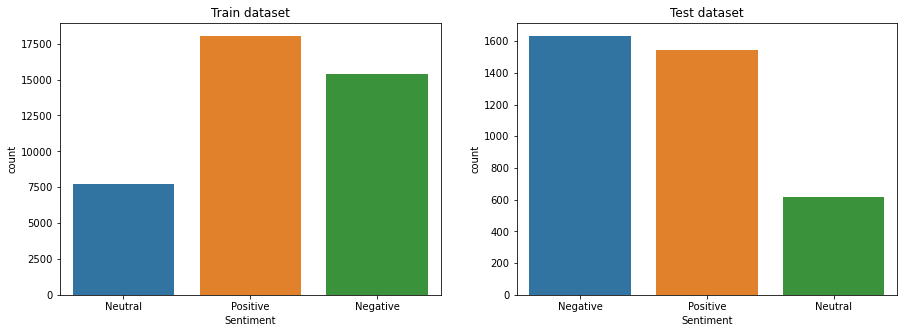

In [8]:
f, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.countplot(train.Sentiment,ax=axes[0])
axes[0].set_title('Train dataset')

sns.countplot(test.Sentiment,ax=axes[1])
axes[1].set_title('Test dataset')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35b0c3">Count Locationwise

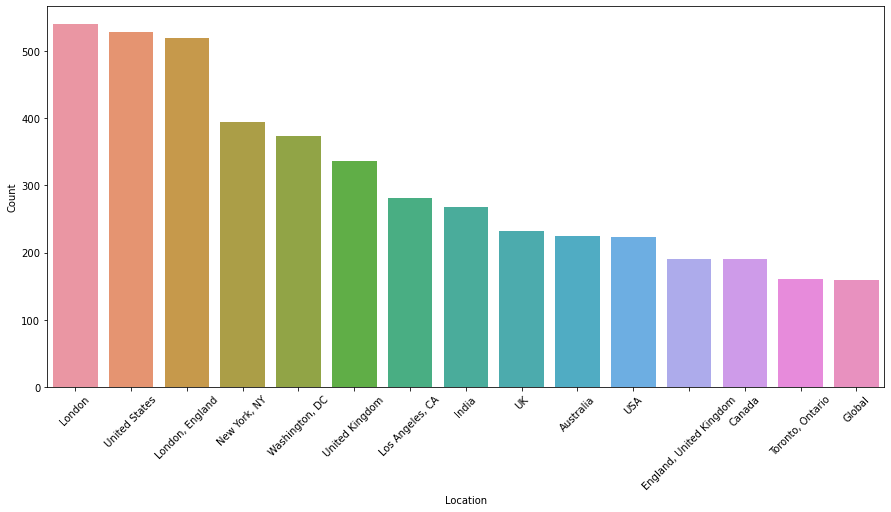

In [9]:
location = train.Location
location = pd.DataFrame(location)
location['Count'] = 1
location = location.groupby('Location').sum().sort_values(by = 'Count', ascending = False).nlargest(15,['Count'])
location = location.reset_index()
plt.figure(figsize=(15,7))
sns.barplot(x = 'Location',y = 'Count', data = location)
plt.xticks(rotation=45)

plt.show()

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#3583c3">Time wise total tweets

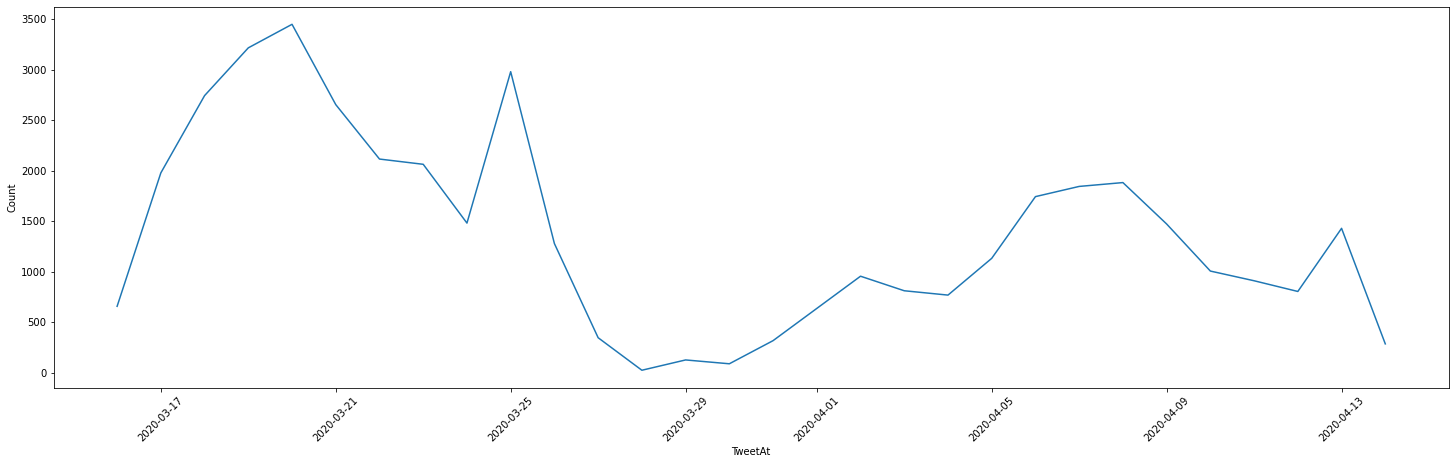

In [10]:
time = train.TweetAt
time = pd.DataFrame(time)
time['Count'] = 1
time = time.groupby('TweetAt').sum()
time = time.reset_index()
time = time.iloc[1:,:]
time['TweetAt'] = pd.to_datetime(time['TweetAt'], format = '%d-%m-%Y')
plt.figure(figsize=(25,7))
sns.lineplot(x = 'TweetAt', y = 'Count', data = time)
plt.xticks(rotation=45)
plt.show()

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35b0c3">Data Cleaning and drop some variables

In [11]:
train = train.drop(['UserName','ScreenName'], axis = 1)
test = test.drop(['UserName','ScreenName'], axis = 1)

In [12]:
train

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative
...,...,...,...,...
41152,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative
41154,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35b0c3">Transform into datetime column

In [13]:
#Transform it into a datetime column
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = '%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format = '%d-%m-%Y')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#354dc3">Tweets cleaning

In [14]:
train.rename(columns={'OriginalTweet': 'Tweet'}, inplace=True)
test.rename(columns={'OriginalTweet': 'Tweet'}, inplace=True)

In [15]:
train.Tweet.head(10)

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
5    As news of the regionÂs first confirmed COVID...
6    Cashier at grocery store was sharing his insig...
7    Was at the supermarket today. Didn't buy toile...
8    Due to COVID-19 our retail store and classroom...
9    For corona prevention,we should stop to buy th...
Name: Tweet, dtype: object

In [16]:
#Remove urls:
train.Tweet = train.Tweet.str.replace('http\S+|www.\S+', '', case=False)
test.Tweet = test.Tweet.str.replace('http\S+|www.\S+', '', case=False)

In [17]:
#Remove hashtag character
train.Tweet = train.Tweet.str.replace('#', '', case=False)
test.Tweet = test.Tweet.str.replace('#', '', case=False)

In [18]:
# Remove punctuation, special characters & mentions:
train.Tweet = train.Tweet.str.replace(r'[^\w\s]', '', case=False)
test.Tweet = test.Tweet.str.replace(r'[^\w\s]', '', case=False)

In [19]:
# #Remove stopwords:
stop_words = set(stopwords.words('english'))
train.Tweet = train.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test.Tweet = test.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [20]:
#Remove non alphabetic words:
train.Tweet = train.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test.Tweet = test.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [21]:
#Remove emptys rows:
train = train[train.Tweet != '']
test = test[test.Tweet != '']

In [22]:
#Initiate a lemmatizer and lemmatize each word in the data
lemmatizer = WordNetLemmatizer()
train.Tweet = train.Tweet.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
test.Tweet = test.Tweet.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#354dc3">check the tweets are cleaned are not

In [23]:
for i in range(0,5):
    print(i,':',train.Tweet[i])
    print(i,':',test.Tweet[i])

0 : MeNyrbie Chrisitv
0 : TRENDING New Yorkers encounter empty supermarket shelf pictured Wegmans Brooklyn soldout online grocer FoodKick MaxDelivery coronavirusfearing shopper stock
1 : advice Talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist GP set online shopping account po adequate supply regular med order
1 : When I couldnt find hand sanitizer Fred Meyer I turned Amazon But pack PurellCheck coronavirus concern driving price
2 : Coronavirus Australia Woolworths give elderly disabled dedicated shopping hour amid outbreak
2 : Find protect loved one coronavirus
3 : My food stock one empty PLEASE dont panic THERE WILL BE ENOUGH FOOD FOR EVERYONE take need Stay calm stay safe coronavirus confinement Confinementotal ConfinementGeneral
3 : Panic buying hit NewYork City anxious shopper stock foodampmedical supply healthcare worker becomes BigApple confirmed coronavirus patient OR Bloomberg staged event QAnon CDC
4 : Me ready go s

In [24]:
train.head()

,Location,TweetAt,Tweet,Sentiment
0,London,2020-03-16,MeNyrbie Chrisitv,Neutral
1,UK,2020-03-16,advice Talk neighbour family exchange phone nu...,Positive
2,Vagabonds,2020-03-16,Coronavirus Australia Woolworths give elderly ...,Positive
3,NaN,2020-03-16,My food stock one empty PLEASE dont panic THER...,Positive
4,NaN,2020-03-16,Me ready go supermarket outbreak Not Im parano...,Negative


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#5635c3">Word Cloud for positive tweets

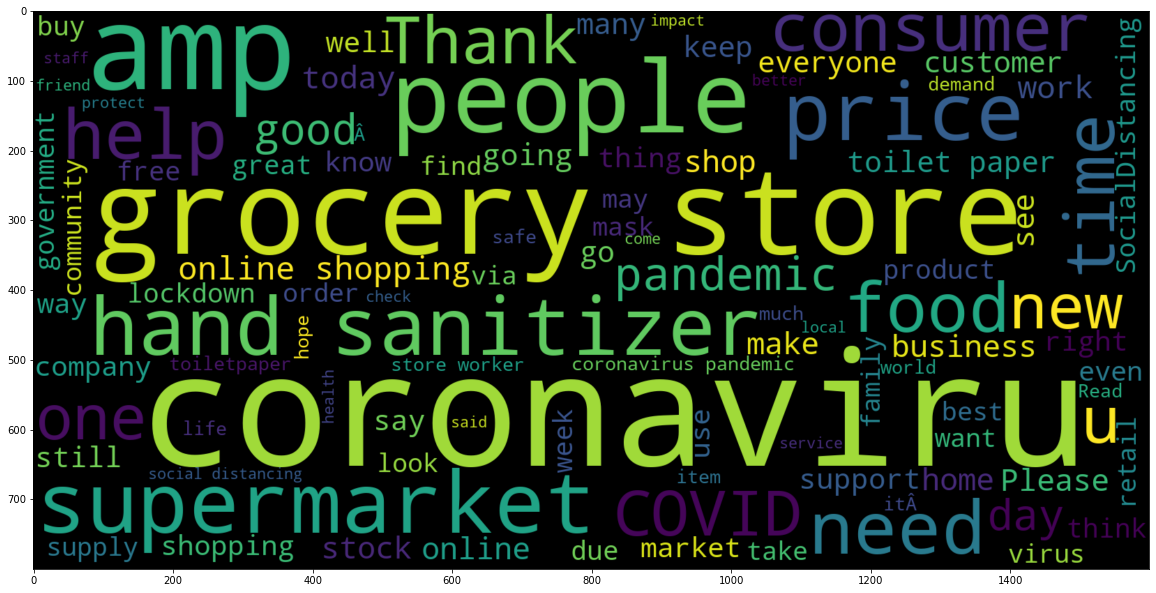

In [25]:
# Top 100 words for positive tweets:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(train[(train.Sentiment == 'Positive') | (train.Sentiment == 'Extremely Positive')].Tweet))
plt.imshow(wc , interpolation = 'bilinear')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#5635c3">Word Cloud for neutral tweets

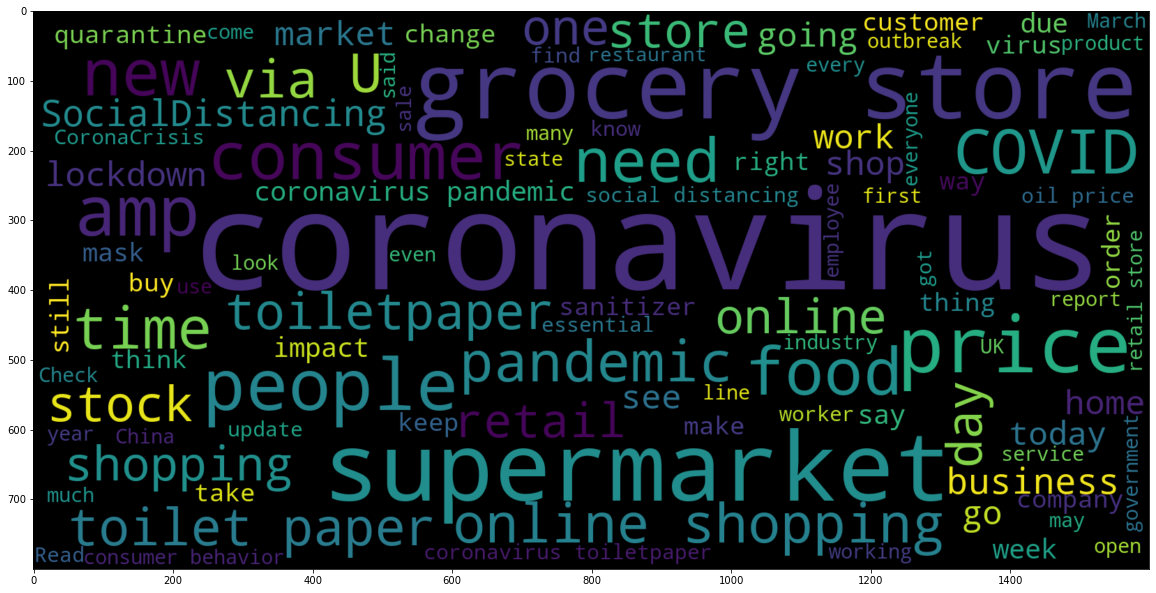

In [26]:
#Top 100 words for neutral tweets:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(train[train.Sentiment == 'Neutral'].Tweet))
plt.imshow(wc , interpolation = 'bilinear')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#5635c3">Word Cloud for negative tweets

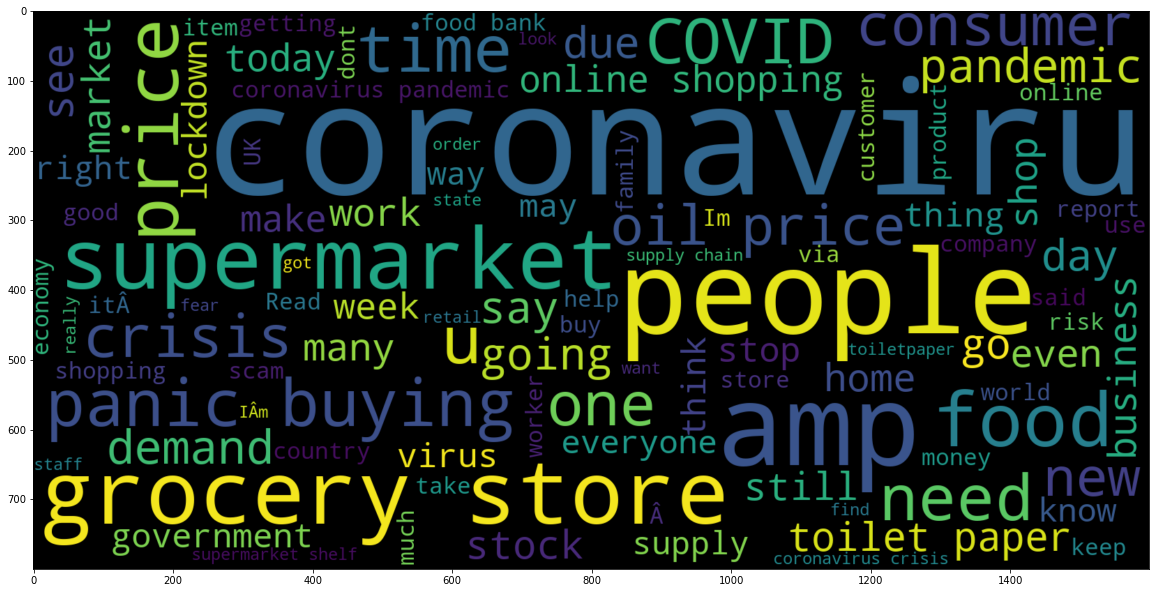

In [27]:
#Top 100 words for negative tweets:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(train[(train.Sentiment == 'Negative') | (train.Sentiment == 'Extremely Negative')].Tweet))
plt.imshow(wc , interpolation = 'bilinear')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#7e35c3">save the train and test cleaned tweets into local hard disk

In [28]:
#Save the data cleaned to be an input for our streamlit app
train.to_csv('/Users/preethamvignesh/Downloads/train_cleaned.csv', index=False)
test.to_csv('/Users/preethamvignesh/Downloads/test_cleaned.csv', index=False)

In [29]:
#Encode the target:
y_train = pd.get_dummies(train.Sentiment).values
y_test = pd.get_dummies(test.Sentiment).values
y_train

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#9835c3">Count Vectorized Model

In [30]:
vectorizer = CountVectorizer()
vectorizer.fit(train.Tweet.values)

X_train = vectorizer.transform(train.Tweet.values)
X_test = vectorizer.transform(test.Tweet.values)

X_train = X_train.toarray()
X_test = X_test.toarray()

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#9835c3">Simple Model (One layer)

In [31]:
opti = Adam(lr = 0.01)

vectorizer_onelayer_count = Sequential()
vectorizer_onelayer_count.add(Dense(16, input_dim = X_train.shape[1], activation = 'relu'))
vectorizer_onelayer_count.add(Dense(3, activation = 'softmax'))

In [32]:
vectorizer_onelayer_count.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
vectorizer_onelayer_count.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                872864    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 872,915
Trainable params: 872,915
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_vectorizer_onelayer = vectorizer_onelayer_count.fit(X_train, y_train,
                    epochs=2,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Epoch 1/2
2572/2572 [==============================] - 30s 12ms/step - loss: 0.7482 - accuracy: 0.6814 - val_loss: 0.5983 - val_accuracy: 0.7788
Epoch 2/2
2572/2572 [==============================] - 31s 12ms/step - loss: 0.2773 - accuracy: 0.9032 - val_loss: 0.6736 - val_accuracy: 0.7659


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#9835c3">save model and history

In [34]:
#Save models and history
vectorizer_onelayer_count.save('/Users/preethamvignesh/Downloads/vectorizer_onelayer_Count.h5')
np.save('/Users/preethamvignesh/Downloads/history_vectorizer_onelayer.npy',history_vectorizer_onelayer.history)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#9835c3">Simple Model (multi layer)

In [35]:
opti = Adam(lr = 0.01)

model_multi_count = Sequential()
model_multi_count.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
model_multi_count.add(Dense(32, activation = 'relu'))
model_multi_count.add(Dense(16, activation = 'relu'))
model_multi_count.add(Dense(3, activation = 'softmax'))

In [36]:
model_multi_count.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_multi_count.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                3491456   
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 3,494,115
Trainable params: 3,494,115
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_multi_count = model_multi_count.fit(X_train, y_train,
                    epochs=2,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Epoch 1/2
2572/2572 [==============================] - 59s 23ms/step - loss: 0.7640 - accuracy: 0.6662 - val_loss: 0.6191 - val_accuracy: 0.7462
Epoch 2/2
2572/2572 [==============================] - 60s 23ms/step - loss: 0.3180 - accuracy: 0.8887 - val_loss: 0.6366 - val_accuracy: 0.7701


In [38]:
# Covid_text_classification_Keras